In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [4]:
datos = []
for dirname, dirnames, filenames in os.walk('./BD/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['./BD/eSAMU 01-01-19 al 30-06-19.xlsx',
 './BD/SAMU 01-07 al 31-10.xlsx',
 './BD/eSAMU.pkl',
 './BD/eSAMU 2019 Noviembre.xlsx']

selecciono algunos...

In [8]:
archivos_eSAMU = [f for f in datos if '.xls' in f]

dejo todo lo que tengo como un solo objeto: BD

In [9]:
BD = pd.DataFrame()
for f in archivos_eSAMU:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48497 entries, 0 to 4565
Data columns (total 44 columns):
Id                          48497 non-null int64
Fecha                       48497 non-null object
Motivo del Llamado          48495 non-null object
Submotivo del Llamado       48495 non-null object
Prioridad                   34803 non-null object
Estado                      48497 non-null object
Edad                        46370 non-null float64
Género                      46137 non-null object
Dirección                   40463 non-null object
Sector                      32147 non-null object
Comuna                      42266 non-null object
Región                      46620 non-null object
Intervención                48497 non-null object
Tipo Traslado               48497 non-null object
Categoría Vehículo          21731 non-null object
Condición Traslado          48497 non-null object
En Regulación               24249 non-null object
En Despacho                 33848 non-null

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [10]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [11]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S')

Luego defino aquellas variables que debo hacer algo similar

In [12]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado'
]

ahora lo hago

In [13]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(
        BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [14]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [15]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2019-06-30 23:50:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,89613
1,2019-06-30 23:42:23,NaT,2019-07-01 03:48:09,2019-07-01 03:50:22,2019-07-01 03:57:43,NaT,NaT,NaT,NaT,2019-07-01 04:31:10,2019-07-01 04:36:14,2019-07-01 04:36:17,R20,89612


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,NaT,NaT,NaT,NaT,NaT,NaT
1,04:05:46,00:02:13,00:07:21,NaT,NaT,NaT


count                   48497
unique                  42373
top       2019-03-19 11:18:05
freq                      210
first     2019-01-01 00:13:09
last      2019-11-30 23:59:39
Name: Fecha, dtype: object

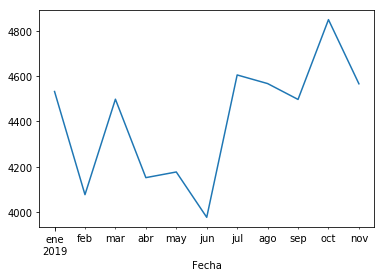

In [16]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [17]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,48497,100.0
Total,48497,100.0


,n,%
Diff_Despacho_Salida,,
False,48496,100.0
True,1,0.0
Total,48497,100.0


,n,%
Diff_salida_enellugar,,
False,48476,99.96
True,21,0.04
Total,48497,100.00


,n,%
Diff_z6_1,,
False,48497,100.0
Total,48497,100.0


,n,%
Diff_z6_2,,
False,48225,99.44
True,272,0.56
Total,48497,100.00


,n,%
Diff_z6_3,,
False,47929,98.83
True,568,1.17
Total,48497,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [18]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [19]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,48497,100.0
Total,48497,100.0


count                     27049
mean     0 days 04:25:57.556175
std      0 days 03:01:02.242611
min             0 days 03:00:09
25%             0 days 03:12:03
50%             0 days 04:04:28
75%             0 days 04:30:00
max             5 days 16:52:15
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,48497,100.0
Total,48497,100.0


count                     21890
mean     0 days 00:08:04.762037
std      0 days 00:17:38.720266
min             0 days 00:00:02
25%             0 days 00:00:51
50%             0 days 00:03:10
75%      0 days 00:08:06.750000
max             0 days 12:09:38
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,48497,100.0
Total,48497,100.0


count                     17299
mean     0 days 00:15:25.263830
std      0 days 00:19:52.489707
min             0 days 00:00:01
25%             0 days 00:04:58
50%             0 days 00:10:27
75%             0 days 00:18:27
max             0 days 10:51:55
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,48497,100.0
Total,48497,100.0


count                      2800
mean     0 days 01:44:50.103571
std      0 days 01:04:28.782140
min             0 days 00:00:03
25%             0 days 01:04:46
50%             0 days 01:30:35
75%      0 days 02:07:57.750000
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,48497,100.0
Total,48497,100.0


count                       422
mean     0 days 01:58:04.732227
std      0 days 02:21:55.383946
min             0 days 00:00:02
25%      0 days 00:21:05.500000
50%      0 days 01:09:37.500000
75%             0 days 02:35:19
max             0 days 11:47:17
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,48497,100.0
Total,48497,100.0


count                      1037
mean     0 days 02:22:32.747348
std      0 days 02:28:45.106244
min             0 days 00:00:02
25%             0 days 00:42:04
50%             0 days 01:30:24
75%             0 days 03:16:17
max             0 days 17:04:19
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [20]:
BD.to_pickle('./BD/eSAMU.pkl')

# Datos generales

In [21]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

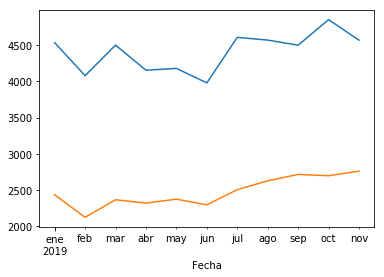

In [22]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

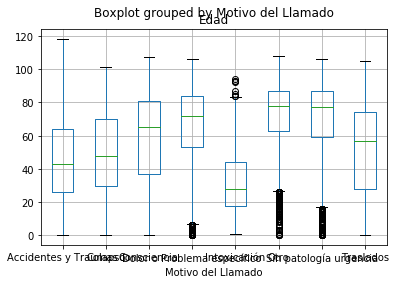

In [26]:
BD.boxplot('Edad', by = 'Motivo del Llamado')
